In [2]:
include("../sensor.jl") # To retrieve Sensor Positions
include("../doa/cbf.jl") # Conventional Beamformer
include("../doa/dbf_freeform.jl") # Differential Beamformer (coordinate-free) 
include("../doa/music.jl") # MUSIC

include("../utils/preprocess.jl")

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


In [219]:
#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

In [220]:
size(tone_sig)
typeof(tone_sig)

Matrix{Float64} (alias for Array{Float64, 2})

In [221]:
include("../signal_generator/generate_sig.jl")
using DSP.Windows: hanning, rect, bartlett
az_gt = -90.0;        # Ground Truth Azimuth Angle (in degrees)
az_gt2 = 120.0;
c0 = 1500;          # Speed of Medium (in m/s)
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
sig1, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater,
                         NFFT, noverlap, hanning, az_gt, c0);
sig2, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater, 
                        NFFT, noverlap, hanning, az_gt2, c0); 
new_sig = sig1 + sig2;


Start Simulating Signal
Signal has size: (320000, 1)


  2.525621 seconds (404.56 k allocations: 1.463 GiB, 34.67% gc time, 7.15% compilation time)
Now Generated Signal has size: (320000, 40)
Start Simulating Signal
Signal has size: (320000, 1)


  1.477797 seconds (180.56 k allocations: 1.453 GiB, 12.80% gc time)
Now Generated Signal has size: (320000, 40)


In [222]:
# Add Noise
using Random
using DSP: db2amp
using SignalAnalysis: PinkGaussian
rng = Random.seed!(1234);
noise_pow = 0; # in dB
noise = rand(rng, size(new_sig,1), size(new_sig,2))
rng = Random.seed!(1234);
pink_noise = rand(rng, PinkGaussian(size(new_sig, 1), 2.0));
noisy_sig = new_sig + db2amp(noise_pow) .* noise;
noisy_sig1 = sig1 + db2amp(noise_pow) .* noise;
noisy_sig2 = sig2 + db2amp(noise_pow) .* noise;

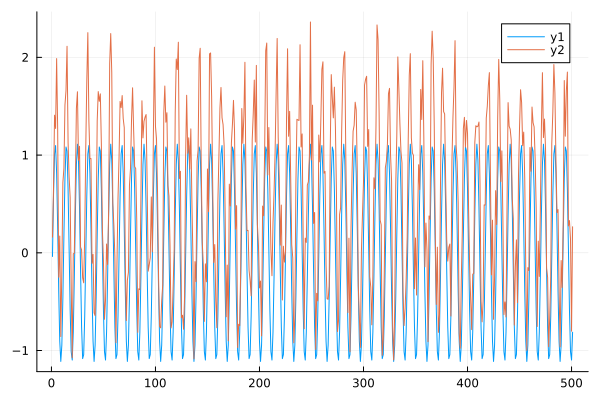

In [215]:
plot(new_sig[64000:64500,1])
plot!(noisy_sig[64000:64500,1])

In [ ]:
include("../utils/delay.jl")
using Plots
# Indicates Delay time at each sensor
delays = generate_time_delay.(sensors_underwater, az_gt, 90, c0);
delays .-= minimum(delays)
check_delayed_signal(tone_sig, new_sig, delays, 50)

In [223]:
include("../doa/cbf.jl")
include("../doa/dbf_freeform.jl")

function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);
new_S1 = filter_freq_per_ch(sig1);
new_S2 = filter_freq_per_ch(sig2);

In [224]:
using Statistics
n_snapshots = 64;
Rx = cov(new_S[:,1:n_snapshots], dims=2);
order = 3;
@time P_cbf, az_list = cbf(Rx, sensors_underwater, freq, c0)
@time P_dbf, az_list = dbf_coFree(Rx, sensors_underwater, order, freq, c0)
Rx1 = cov(new_S1[:,1:n_snapshots], dims=2);
@time P1_cbf, az_list = cbf(Rx1, sensors_underwater, freq, c0)
@time P1_dbf, az_list = dbf_coFree(Rx1, sensors_underwater, order, freq, c0)
Rx2 = cov(new_S2[:,1:n_snapshots], dims=2);
@time P2_cbf, az_list = cbf(Rx2, sensors_underwater, freq, c0)
@time P2_dbf, az_list = dbf_coFree(Rx2, sensors_underwater, order, freq, c0)

  0.098986 seconds (312.77 k allocations: 16.707 MiB, 97.35% compilation time)


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.127247 seconds (209.56 k allocations: 11.190 MiB, 98.40% compilation time)
  0.003502 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.002053 seconds (13.36 k allocations: 1.106 MiB)
  0.003947 seconds (15.90 k allocations: 1.631 MiB)


weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.003200 seconds (13.40 k allocations: 1.111 MiB)


([28084.476884220836, 32302.645657590736, 36451.164562348684, 40462.080726473934, 44273.415293958264, 47829.52244137722, 51081.37386229095, 53986.767757593916, 56510.46214360831, 58624.23306422694  …  486.3859493142934, 1553.5750885217458, 3338.9452019928767, 5747.766621426403, 8685.23434812889, 12057.330542573694, 15771.654115934249, 19738.210267875955, 23870.153333206843, 28084.47688424883], LinRange{Float64}(-180.0, 180.0, 361), ComplexF64[0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … -0.000202821959874734 - 0.000947628789081802im -0.0007655650718008316 - 0.00024881805381223124im; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 - 0.014914890292374024im -0.004392940862485556 - 0.01352265060754891im; … ; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 + 0.014914890292374024im -0.004392940862485556 + 0.01352265060754891im; 0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … 0.00020282195

In [200]:
function normalize_P(P, az_list) 
    (P_max, max_idx) = findmax(P);
    return (P ./ P_max), az_list[max_idx]
end

P_cbf_norm, az_cbf_max = normalize_P(P_cbf, az_list)
P_dbf_norm, az_dbf_max = normalize_P(P_dbf, az_list)
P1_cbf_norm, az1_cbf_max = normalize_P(P1_cbf, az_list)
P1_dbf_norm, az1_dbf_max = normalize_P(P1_dbf, az_list)
P2_cbf_norm, az2_cbf_max = normalize_P(P2_cbf, az_list)
P2_dbf_norm, az2_dbf_max = normalize_P(P2_dbf, az_list)

([0.08134366320965511, 0.08461553637515307, 0.08820138123786304, 0.09200325913979114, 0.09592789476423698, 0.09988751665152816, 0.10380060896890769, 0.10759256802042583, 0.11119625815171912, 0.11455246292037577  …  0.08320077322319062, 0.07897431384650413, 0.07598193749923678, 0.0741316955632958, 0.07332629974747917, 0.0734643145731159, 0.07444135853998678, 0.07615130101202451, 0.07848744210196028, 0.08134366320965504], 128.0)

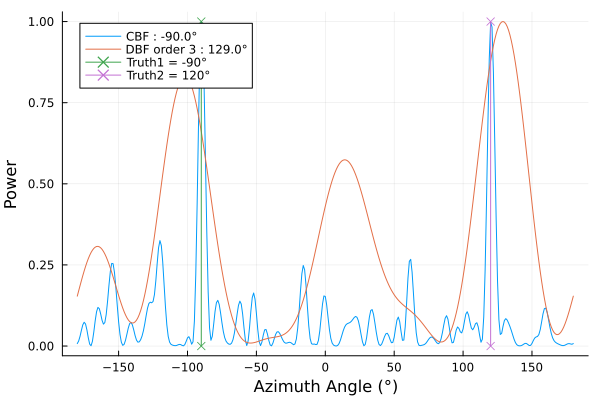

In [201]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")


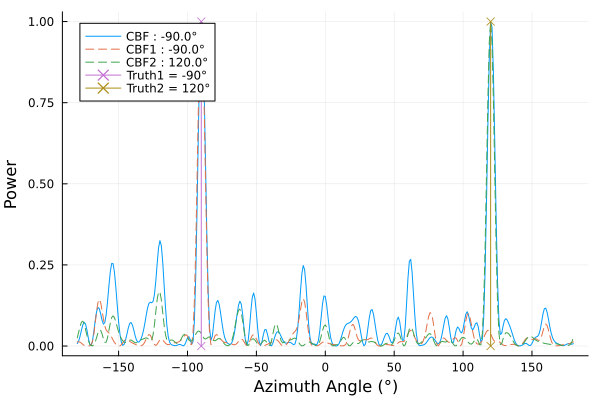

In [202]:
plot(az_list, P_cbf_norm, label="CBF : $(az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_cbf_norm, label="CBF1 : $(az1_cbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_cbf_norm, label="CBF2 : $(az2_cbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

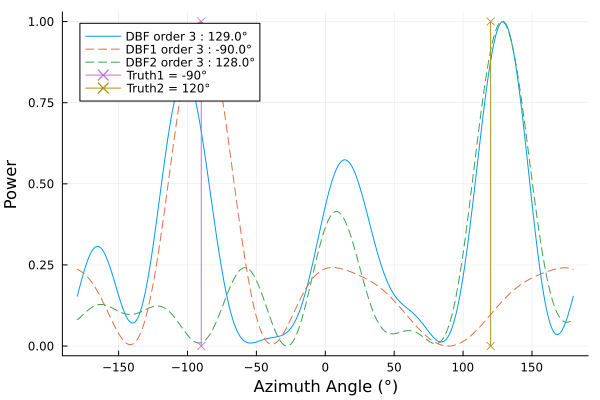

In [225]:
plot(az_list, P_dbf_norm, label="DBF order $order : $(az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1_dbf_norm, label="DBF1 order $order : $(az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2_dbf_norm, label="DBF2 order $order : $(az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")


In [226]:
noisy_S = filter_freq_per_ch(noisy_sig);
noisy_S1 = filter_freq_per_ch(noisy_sig1);
noisy_S2 = filter_freq_per_ch(noisy_sig2);

using Statistics
n_snapshots = 64;
noisy_Rx = cov(noisy_S[:,1:n_snapshots], dims=2);
order = 3;
@time Pn_cbf, az_list = cbf(noisy_Rx, sensors_underwater, freq, c0)
@time Pn_dbf, az_list = dbf_coFree(noisy_Rx, sensors_underwater, order, freq, c0)
noisy_Rx1 = cov(noisy_S1[:,1:n_snapshots], dims=2);
@time P1n_cbf, az_list = cbf(noisy_Rx1, sensors_underwater, freq, c0)
@time P1n_dbf, az_list = dbf_coFree(noisy_Rx1, sensors_underwater, order, freq, c0)
noisy_Rx2 = cov(noisy_S2[:,1:n_snapshots], dims=2);
@time P2n_cbf, az_list = cbf(noisy_Rx2, sensors_underwater, freq, c0)
@time P2n_dbf, az_list = dbf_coFree(noisy_Rx2, sensors_underwater, order, freq, c0)

  0.003715 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.002169 seconds (13.36 k allocations: 1.106 MiB)
  0.002615 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001670 seconds (13.36 k allocations: 1.105 MiB)
  0.002575 seconds (15.90 k allocations: 1.631 MiB)
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
  0.001671 seconds (13.36 k allocations: 1.105 MiB)


([222512.02531962463, 230062.58754971414, 237955.53210270504, 246070.20351752714, 254288.8180287853, 262497.4421073363, 270586.9177191022, 278453.7265030954, 286000.78572323476, 293138.16957364517  …  189931.2870555442, 189023.335740248, 189496.58899511094, 191252.89250268767, 194187.2725649342, 198188.9734478718, 203142.52800394315, 208928.85158664754, 215426.34914031238, 222512.0253196009], LinRange{Float64}(-180.0, 180.0, 361), ComplexF64[0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … -0.000202821959874734 - 0.000947628789081802im -0.0007655650718008316 - 0.00024881805381223124im; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 - 0.014914890292374024im -0.004392940862485556 - 0.01352265060754891im; … ; -0.0013695261293235575 + 0.0im -0.005463097987779859 + 0.0im … 0.006009700956152899 + 0.014914890292374024im -0.004392940862485556 + 0.01352265060754891im; 0.0 + 2.3908203039040495e-5im 0.0 + 0.00019087261959543656im … 0.000202821959

In [227]:
Pn_cbf_norm, n_az_cbf_max = normalize_P(Pn_cbf, az_list)
Pn_dbf_norm, n_az_dbf_max = normalize_P(Pn_dbf, az_list)
P1n_cbf_norm, n_az1_cbf_max = normalize_P(P1n_cbf, az_list)
P1n_dbf_norm, n_az1_dbf_max = normalize_P(P1n_dbf, az_list)
P2n_cbf_norm, n_az2_cbf_max = normalize_P(P2n_cbf, az_list)
P2n_dbf_norm, n_az2_dbf_max = normalize_P(P2n_dbf, az_list)

([0.18471711051070688, 0.19098516742075472, 0.19753745109690854, 0.20427380008450444, 0.21109643685094565, 0.2179107801156772, 0.224626212948603, 0.2311568001626295, 0.2374219490686036, 0.2433470082628642  …  0.15767039327463048, 0.1569166625798287, 0.15730953111649543, 0.158767516628215, 0.1612034757879944, 0.16452546534412105, 0.16863763089131023, 0.1734411149778076, 0.17883497614975705, 0.18471711051068718], 124.0)

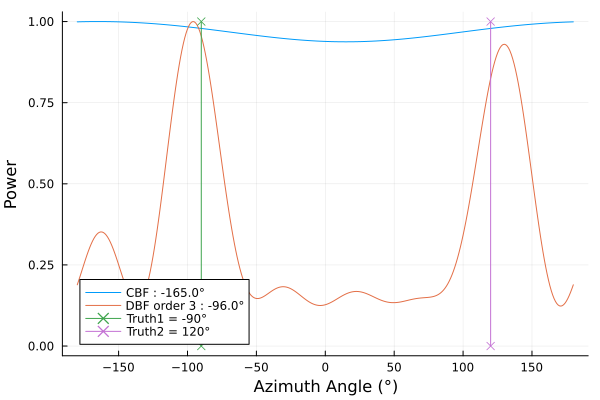

In [231]:
plot(az_list, Pn_cbf_norm, label="CBF : $(n_az_cbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°")

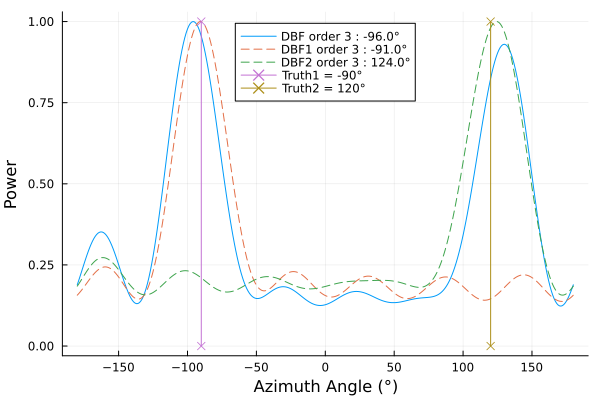

In [232]:
plot(az_list, Pn_dbf_norm, label="DBF order $order : $(n_az_dbf_max)°")
xlabel!("Azimuth Angle (°)");
ylabel!("Power");
plot!(az_list, P1n_dbf_norm, label="DBF1 order $order : $(n_az1_dbf_max)°",
    linestyle=:dash);
plot!(az_list, P2n_dbf_norm, label="DBF2 order $order : $(n_az2_dbf_max)°",
    linestyle=:dash);
plot!([az_gt; az_gt], [0; 1], marker=:x, label="Truth1 = $(az_gt)°")
plot!([az_gt2; az_gt2], [0; 1], marker=:x, label="Truth2 = $(az_gt2)°", legend=:top)

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


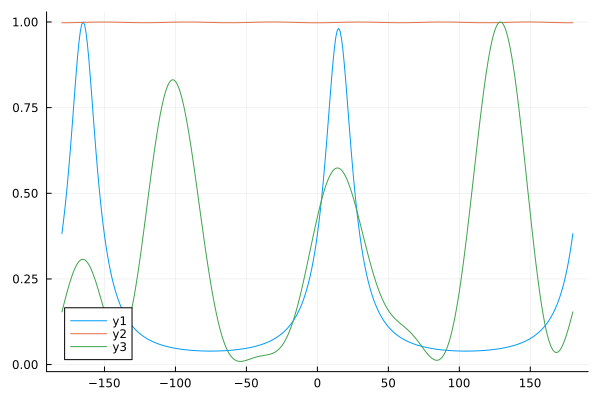

In [229]:
include("./doa/music.jl")
eig_values, Rs, Rn = get_eigensubspace(Rx, 2)
P_music, az_list = cbf(Rn, sensors_underwater, freq, c0);
P_dbf_music, az_list = dbf_coFree(Rn, sensors_underwater, order, freq, c0)

P_music_norm, az_music_max = normalize_P(1 ./ P_music, az_list)
P_dbfmusic_norm, az_dbfmusic_max = normalize_P(1 ./ P_dbf_music, az_list)
plot(az_list, P_music_norm)
plot!(az_list, P_dbfmusic_norm)
plot!(az_list, P_dbf_norm)
# println(eig_values)

weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7
weighting vector: Rational[1//7, 1//7, 1//7, 1//7, 1//7, 1//7, 1//7] has sum 1//1
ψ has rank 7


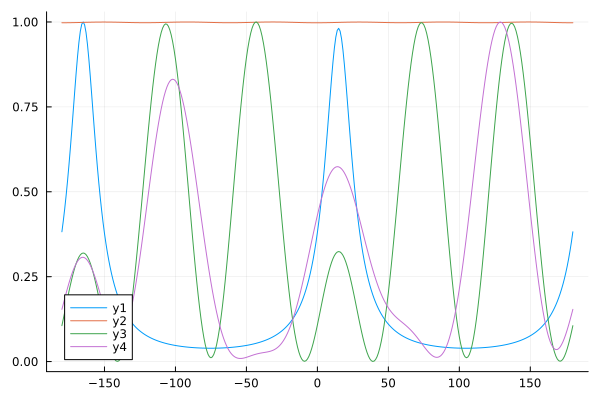

In [230]:
P_music, az_list = cbf(Rn, sensors_underwater, freq, c0);
P_dbf_music, az_list = dbf_coFree(Rn, sensors_underwater, order, freq, c0)
P_dbf_rs, az_list = dbf_coFree(Rs, sensors_underwater, order, freq, c0)

P_music_norm, az_music_max = normalize_P(1 ./ P_music, az_list)
P_dbfmusic_norm, az_dbfmusic_max = normalize_P(1 ./ P_dbf_music, az_list)
P_dbfrs_norm, az_dbfrs_max = normalize_P(P_dbf_rs, az_list)
plot(az_list, P_music_norm)
plot!(az_list, P_dbfmusic_norm)
plot!(az_list, P_dbfrs_norm)
plot!(az_list, P_dbf_norm)

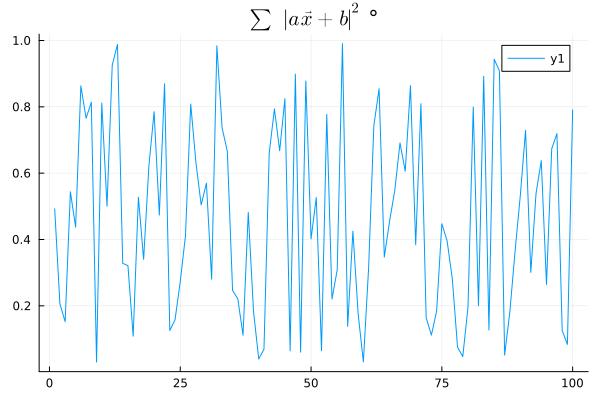

In [160]:
using Plots, LaTeXStrings
plot(rand(100))
title!(L"$\sum |a\vec{x} + b|^{2}$ °")

In [ ]:
wavwrite()

1000-element Vector{Float64}:
 0.5798621201341324
 0.4112941179498505
 0.9721360824554687
 0.014908849285099945
 0.520354993723718
 0.6395615996802734
 0.8396219340580711
 0.967142768915383
 0.7897644095351307
 0.6960406981439002
 ⋮
 0.7938000916760949
 0.10667797515891897
 0.523289210236778
 0.21040115028811368
 0.6784581857267311
 0.4242946548331029
 0.48155359118450025
 0.4015278156986538
 0.5898496301286759